<a href="https://colab.research.google.com/github/robotstech/similarity-ml/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

## Load data

In [5]:
import numpy as np
from tensorflow import keras


# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()


x_train = np.expand_dims(x_train, axis=-1) / 255.
x_test = np.expand_dims(x_test, axis=-1) / 255.

print(f"{x_train.shape=} {y_train.shape=}")
print(f"{x_train.shape=} {y_test.shape=}")

11490434/11490434 [==============================] - 0s 0us/step
x_train.shape=(60000, 28, 28, 1) y_train.shape=(60000,)
x_train.shape=(60000, 28, 28, 1) y_test.shape=(10000,)


## Visualise Data

### Label distribution

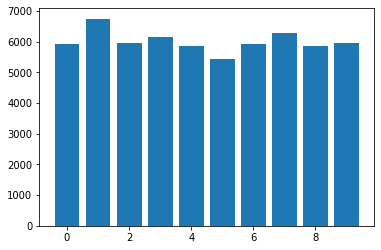

In [6]:
from collections import Counter
from matplotlib import pyplot as plt

label_distribution = Counter(y_train)
plt.bar(label_distribution.keys(), label_distribution.values())
plt.show()

hello